# 1. Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# SentenceTransformers for embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

2025-09-10 21:43:52.406171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757540632.579640      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757540632.626738      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Dataset:

It contains two set of dataset; resume and job description
- Resume.csv contains ID, resume and category
- Training_data.csv contains company name, job description and position title

In [2]:
# Resume dataset:
resumes_df = pd.read_csv("/kaggle/input/resume-and-job-description/Resume.csv")

resumes_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [3]:
# job description dataset
jobs_df = pd.read_csv("/kaggle/input/resume-and-job-description/training_data.csv")

jobs_df.head()

,company_name,job_description,position_title,description_length,model_response
0,Google,minimum qualifications\nbachelors degree or eq...,Sales Specialist,2727,"{\n ""Core Responsibilities"": ""Responsible fo..."
1,Apple,description\nas an asc you will be highly infl...,Apple Solutions Consultant,828,"{\n ""Core Responsibilities"": ""as an asc you ..."
2,Netflix,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,3205,"{\n ""Core Responsibilities"": ""Help drive bus..."
3,Robert Half,description\n\nweb designers looking to expand...,Web Designer,2489,"{\n ""Core Responsibilities"": ""Designing webs..."
4,TrackFive,at trackfive weve got big goals were on a miss...,Web Developer,3167,"{\n ""Core Responsibilities"": ""Build and layo..."


# 3. Exploratory Data Analysis (EDA):

In [4]:
print("Number of resumes:", len(resumes_df))

print("Number of job descriptions:", len(jobs_df))

Number of resumes: 2484
Number of job descriptions: 853


In [5]:
category_counts = resumes_df['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']
print(category_counts)

                  Category  Count
0   INFORMATION-TECHNOLOGY    120
1     BUSINESS-DEVELOPMENT    120
2                 ADVOCATE    118
3                     CHEF    118
4              ENGINEERING    118
5               ACCOUNTANT    118
6                  FINANCE    118
7                  FITNESS    117
8                 AVIATION    117
9                    SALES    116
10                 BANKING    115
11              HEALTHCARE    115
12              CONSULTANT    115
13            CONSTRUCTION    112
14        PUBLIC-RELATIONS    111
15                      HR    110
16                DESIGNER    107
17                    ARTS    103
18                 TEACHER    102
19                 APPAREL     97
20           DIGITAL-MEDIA     96
21             AGRICULTURE     63
22              AUTOMOBILE     36
23                     BPO     22


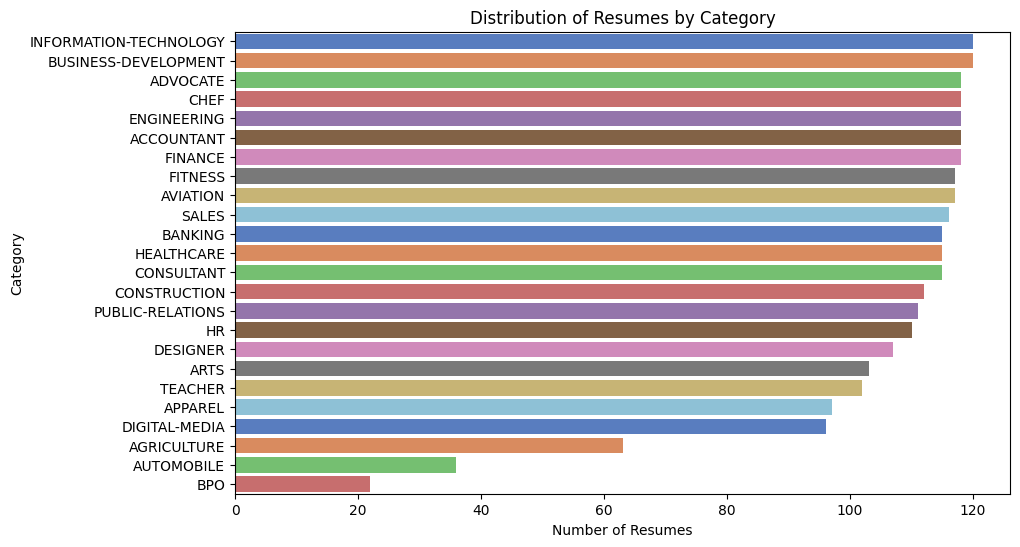

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Category', data=category_counts, palette='muted')
plt.title("Distribution of Resumes by Category")
plt.xlabel("Number of Resumes")
plt.ylabel("Category")
plt.show()

In [7]:
job_title_counts = jobs_df['position_title'].value_counts().reset_index()
job_title_counts.columns = ['Position Title', 'Count']
print(job_title_counts.head(30))

                                 Position Title  Count
0                               Sales Associate      9
1                        Retail Sales Associate      9
2                               Project Manager      7
3                               Inventory Clerk      6
4                         Systems Administrator      6
5                           Executive Assistant      5
6                                   Bank Teller      5
7                          Marketing Specialist      5
8                              Data Entry Clerk      5
9                                 Web Developer      5
10                             Marketing Intern      4
11              Customer Service Representative      4
12                         Supply Chain Analyst      4
13                            Real Estate Agent      4
14                      Chief Executive Officer      4
15                            Warehouse Manager      4
16                        Development Associate      3
17        

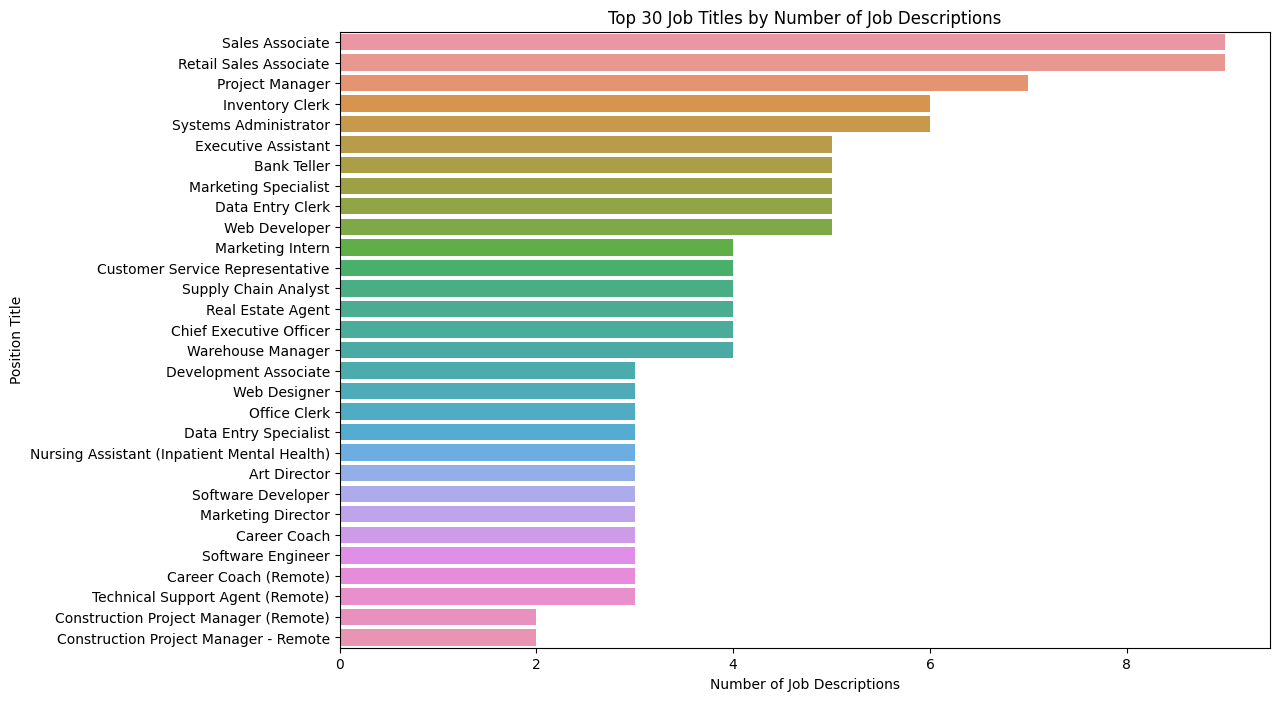

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(x='Count', y='Position Title', data=job_title_counts.head(30))
plt.title("Top 30 Job Titles by Number of Job Descriptions")
plt.xlabel("Number of Job Descriptions")
plt.ylabel("Position Title")
plt.show()

In [9]:
def top_words(text_series, n=20):
    all_text = ' '.join(text_series).lower()
    all_text = re.sub(r'[^a-z\s]', '', all_text)
    words = all_text.split()
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(n)

In [10]:
print("Top Resume Words:", top_words(resumes_df['Resume_str']))
print("\nTop Job Description Words:", top_words(jobs_df['job_description']))

Top Resume Words: [('state', 16063), ('city', 15045), ('company', 14663), ('management', 11996), ('name', 11737), ('sales', 8124), ('skills', 7695), ('business', 7686), ('customer', 7607), ('new', 6336), ('service', 5994), ('team', 5871), ('development', 5648), ('experience', 5615), ('training', 5557), ('project', 5244), ('work', 4700), ('information', 4471), ('marketing', 4360), ('manager', 4309)]

Top Job Description Words: [('experience', 2610), ('work', 2316), ('team', 1770), ('skills', 1449), ('business', 1386), ('ability', 1326), ('management', 1148), ('job', 1114), ('customer', 1077), ('sales', 1053), ('including', 1048), ('required', 943), ('new', 907), ('development', 898), ('support', 893), ('company', 891), ('marketing', 861), ('position', 835), ('years', 809), ('service', 776)]


In [11]:
resume_top_words = dict(top_words(resumes_df['Resume_str'], n=100))
jd_top_words = dict(top_words(jobs_df['job_description'], n=100))

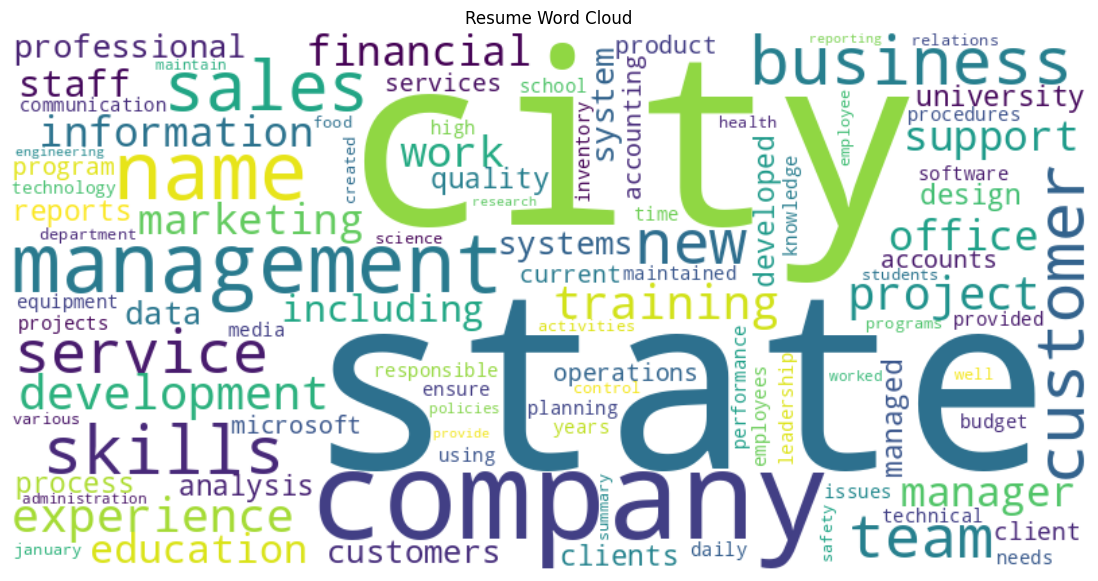

In [12]:
# Resume Word Cloud
wc_resume = WordCloud(width=800, height=400, background_color='white')
wc_resume.generate_from_frequencies(resume_top_words)
plt.figure(figsize=(15,7))
plt.imshow(wc_resume, interpolation='bilinear')
plt.axis('off')
plt.title("Resume Word Cloud")
plt.show()


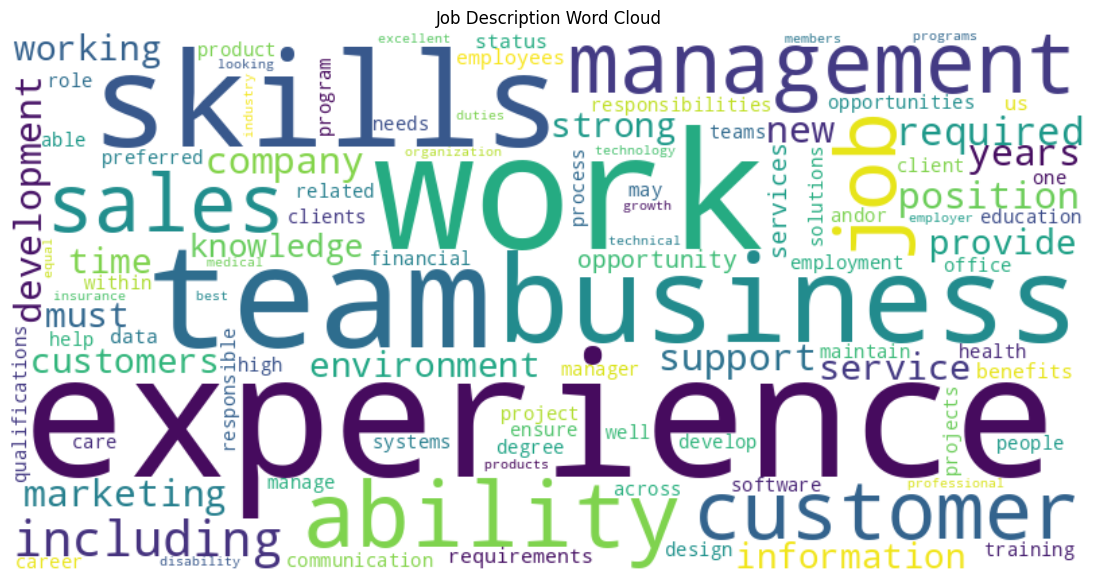

In [13]:
# Job Description Word Cloud
wc_jd = WordCloud(width=800, height=400, background_color='white')
wc_jd.generate_from_frequencies(jd_top_words)
plt.figure(figsize=(15,7))
plt.imshow(wc_jd, interpolation='bilinear')
plt.axis('off')
plt.title("Job Description Word Cloud")
plt.show()


# 4. Data Cleaning

In [14]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [15]:
resumes_df['clean_resume'] = resumes_df['Resume_str'].apply(clean_text)
jobs_df['clean_jd'] = jobs_df['job_description'].apply(clean_text)


# 5. DistilBERT Embeddings

In [16]:
model_name = "distilbert-base-nli-stsb-mean-tokens"
model = SentenceTransformer(model_name)
print("Loaded model:", model_name)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded model: distilbert-base-nli-stsb-mean-tokens


In [17]:
resume_texts = resumes_df['clean_resume'].tolist()
jd_texts = jobs_df['clean_jd'].tolist()

In [18]:
resume_embeddings = model.encode(resume_texts, batch_size=32, show_progress_bar=True, convert_to_numpy=True)
jd_embeddings = model.encode(jd_texts, batch_size=32, show_progress_bar=True, convert_to_numpy=True)


Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

In [19]:
resume_embeddings = resume_embeddings.astype(np.float32)
jd_embeddings = jd_embeddings.astype(np.float32)


In [20]:
print("Resume embeddings shape:", resume_embeddings.shape)
print("JD embeddings shape:", jd_embeddings.shape)

Resume embeddings shape: (2484, 768)
JD embeddings shape: (853, 768)


# 6. Cosine Similarity:

In [21]:
similarity_matrix = cosine_similarity(resume_embeddings, jd_embeddings)
print("Similarity matrix shape:", similarity_matrix.shape)

Similarity matrix shape: (2484, 853)


# 7. Evaluation:

In [22]:
best_matches = []
for i, resume in enumerate(resumes_df['Resume_str']):
    best_jd_idx = np.argmax(similarity_matrix[i])
    best_score = similarity_matrix[i][best_jd_idx]
    best_matches.append({
        'ID': resumes_df.iloc[i]['ID'],  # Use ID from resumes_df
        'resume_str': resume,
        'best_job_description': jobs_df.iloc[best_jd_idx]['job_description'],
        'job_title': jobs_df.iloc[best_jd_idx]['position_title'],
        'similarity_score': float(best_score)
    })


In [23]:
matches_df = pd.DataFrame(best_matches)
matches_df.head()

,ID,resume_str,best_job_description,job_title,similarity_score
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,job summary\n\nthe team member in this positio...,COORDINATOR - MARKETING,0.774130
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",marketing director elearning\n\nresumes to ca...,"Marketing Director – E-Learning – Columbus, OH",0.802016
2,33176873,HR DIRECTOR Summary Over 2...,human resources generalist aveda institutes l...,Human Resources Generalist,0.763569
3,27018550,HR SPECIALIST Summary Dedica...,job description\n\nwe are looking for a highly...,Data Entry - Work from Home - International Ap...,0.819120
4,17812897,HR MANAGER Skill Highlights ...,marketing director elearning\n\nresumes to ca...,"Marketing Director – E-Learning – Columbus, OH",0.753869


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


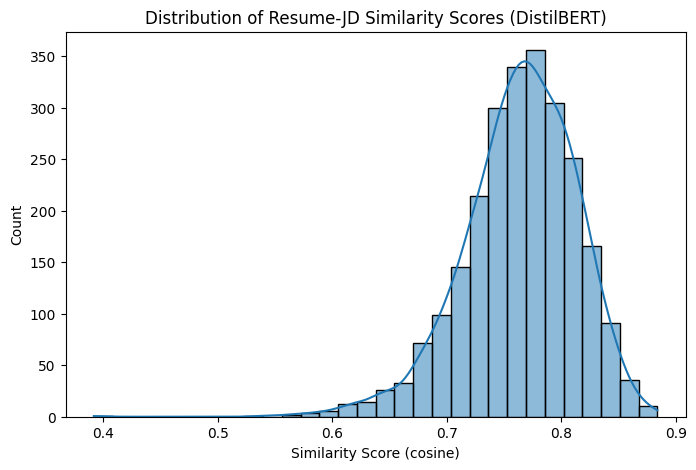

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(matches_df['similarity_score'], bins=30, kde=True)
plt.title("Distribution of Resume-JD Similarity Scores (DistilBERT)")
plt.xlabel("Similarity Score (cosine)")
plt.show()

In [25]:
# Strong matches
strong_matches = matches_df[matches_df['similarity_score'] > 0.5]
print("Number of strong matches:", len(strong_matches))
strong_matches.head()


Number of strong matches: 2483


,ID,resume_str,best_job_description,job_title,similarity_score
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,job summary\n\nthe team member in this positio...,COORDINATOR - MARKETING,0.774130
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",marketing director elearning\n\nresumes to ca...,"Marketing Director – E-Learning – Columbus, OH",0.802016
2,33176873,HR DIRECTOR Summary Over 2...,human resources generalist aveda institutes l...,Human Resources Generalist,0.763569
3,27018550,HR SPECIALIST Summary Dedica...,job description\n\nwe are looking for a highly...,Data Entry - Work from Home - International Ap...,0.819120
4,17812897,HR MANAGER Skill Highlights ...,marketing director elearning\n\nresumes to ca...,"Marketing Director – E-Learning – Columbus, OH",0.753869


### Top resume matches for sample job description:

In [26]:
top_n = 5
for jd_idx in range(2):  
    job_company = jobs_df.iloc[jd_idx]['company_name']
    job_title = jobs_df.iloc[jd_idx]['position_title']
    job_description = clean_text(jobs_df.iloc[jd_idx]['job_description'])
    
    print(f"\n{'='*80}")
    print(f"Job {jd_idx+1}: {job_title} at {job_company}")
    print(f"Job Description: {job_description[:50]}...")
    print(f"{'-'*80}")
    
    scores = similarity_matrix[:, jd_idx]
    top_resume_indices = scores.argsort()[::-1][:top_n]
    
    for rank, idx in enumerate(top_resume_indices, 1):
        resume_text = clean_text(resumes_df.iloc[idx]['Resume_str'])
        similarity_score = scores[idx]
        resume_id = resumes_df.iloc[idx]['ID']
        print(f"Top {rank} Resume (ID: {resume_id}) | Similarity Score: {similarity_score:.4f}")
        print(f"Resume Text:\n {resume_text[:70]}...\n")


Job 1: Sales Specialist at Google
Job Description: minimum qualifications bachelors degree or equival...
--------------------------------------------------------------------------------
Top 1 Resume (ID: 13964744) | Similarity Score: 0.7825
Resume Text:
 team lead senior analyst professional summary mba in business manageme...

Top 2 Resume (ID: 12377803) | Similarity Score: 0.7660
Resume Text:
 business development manager highlights business development skills id...

Top 3 Resume (ID: 44185767) | Similarity Score: 0.7644
Resume Text:
 solution designer career overview solutionsoriented consultant possess...

Top 4 Resume (ID: 36805025) | Similarity Score: 0.7620
Resume Text:
 business development executive profile over years of demonstrated oper...

Top 5 Resume (ID: 26987539) | Similarity Score: 0.7613
Resume Text:
 business banking specialist summary over years experience supervising ...


Job 2: Apple Solutions Consultant at Apple
Job Description: description as an asc you will b